In [1]:
import numpy as np
import pandas as pd

import ipywidgets as widgets
from IPython.display import display, Math

import dtmc
import mcviz

Loading BokehJS ...

In [2]:
import bokeh.plotting as bplt
from bokeh.models import Range1d, LabelSet, ColumnDataSource
from bokeh.models.glyphs import VBar
from bokeh.io import output_notebook, push_notebook
output_notebook()

Loading BokehJS ...

# DTMC: Section 6 - The Stationary Distribution

In Section 5 we learned how to organize a Markov chain into communication classes and classify each state as recurrent or transient.  For a communication class whose states are transient, the Markov chain will move among the states in the class for some finite (but random) period of time before leaving and never returning.  For a communication class whose states are recurrent, the Markov chain will continue to move among the states in that class forever (and never leave the communication class).

## The Long-Run Proportion of Time Spent in a State

Consider the ride-share driver example from Section 4.  What proportion of his passengers' destinations are in Coral Gables?  Clearly this is subject to random fluctuations, but we might expect that, over the long-run this will stabilize to some value.

Mathematically, we write this as:

$$ \text{long-run proportion of passengers going to Coral Gables} = \lim_{n \to \infty} \frac{1}{n} \sum_{k=1}^n \mathbf{1}\{X_k = 1\} $$

where $\mathbf{1}\{\cdot\}$ is the indicator random variable.  Given a probability space $(\Omega, \mathcal{F}, \mathsf{P})$ and event $A \in \mathcal{F}$, the random variable $\mathbf{1}\{A\} : \Omega \to [0, 1]$ is defined to be
$$\mathbf{1}\{A\}(\omega) \overset{\mathsf{def}}{=} \begin{cases}
    1 & \text{if } \omega \in A \\
    0 & \text{otherwise}
  \end{cases}$$
  
You can think of $\sum_{k=1}^n \mathbf{1}\{X_k = 1\}$ as a simple counter: it adds $1$ when the Markov chain visits state $1$ (the $k$th passenger goes to Coral Gables) and ignores the other states (adds $0$ otherwise).  Dividing the sum by $n$ (total time steps) normalizes this to the proportion of visits.  Taking the limit as $n \to \infty$ considers the long-run.  

For a general DTMC on state space $\mathcal{S}$ and any state $j \in \mathcal{S}$:

$$ \text{long-run proportion of time spent in state $j$} = \underbrace{\lim_{n \to \infty}}_{\text{long-run}} \overbrace{\frac{1}{n}}^{\text{proportion}} \underbrace{\sum_{k=1}^n \mathbf{1}\{X_k = j\}}_{\text{time spent in state $j$}} $$

**Remark:** Remember that we are in discrete time, so the ”time spent in” a state means the number of visits to that state.  When we encounter this same idea in continuous-time Markov chains, we will take into account the duration of each visit.



In [3]:
S = [1, 2, 3, 4]
P = np.array([[0.3, 0.2, 0.4, 0.1],
              [0.4, 0.1, 0.4, 0.1],
              [0.7, 0.2, 0, 0.1],
              [0.5, 0.3, 0.1, 0.1]
             ])
names = ['Coral Gables', 'Kendall', 'Downtown', 'Miami Beach']

In [5]:
d_0 = [1, 0, 0, 0]
steps = 1000
sample_path = pd.DataFrame(dtmc.sim_path(P, d_0, steps=steps, S=S), 
                           index=pd.Index(range(0,steps+1), name='step'),
                           columns=['path'])
slider = widgets.IntSlider(value=1, min=1, max=steps, description='step')


In [6]:
def sliding_table(path, current = 0, num_rows = 10, loc = 0):
    style_past = 'color: gray'
    style_present = 'background-color: rgba(255, 0, 0, 0.6)'
    style_future = ''
    start = max(0, current-loc)
    end = start + num_rows
    if start == current-loc:
        highlight = loc
    else:
        highlight = current
    df = path[start:end]
    def highlight_row(s):
        strs = ['']*len(df)
        strs[0:highlight] = [style_past]*highlight
        strs[highlight] = style_present
        strs[highlight+1:] = [style_future]*(len(df)-highlight-1)
        return strs
    
    display(df.style.apply(highlight_row))

def path_state_counts(path, S):
    indic = pd.get_dummies(path[1:]).reindex(S, axis='columns', fill_value=0)
    count = indic.cumsum()
    prop = count/np.transpose(np.broadcast_to(path.index.values[1:], (len(S), len(path.index)-1)))
    indic = indic.rename(columns=dict(zip(indic.columns, [f'is in state {j}' for j in S])))
    count = count.rename(columns=dict(zip(count.columns, [f'time in state {j}' for j in S])))
    prop = prop.rename(columns=dict(zip(prop.columns, [f'proportion in state {j}' for j in S])))
    return indic, count, prop

indic, count, prop = path_state_counts(sample_path['path'], S)
j = [2]
loc = [S.index(state) for state in j]
state_path = pd.DataFrame(sample_path['path'][1:]).join(indic.iloc[:,loc]).join(count.iloc[:,loc]).join(prop.iloc[:,loc])
widgets.interact(lambda step: sliding_table(state_path, step-1), step=(1, len(sample_path.index)-1));

interactive(children=(IntSlider(value=500, description='step', max=1000, min=1), Output()), _dom_classes=('wid…

Connecting the table for the generated sample path above to the mathematical notation introduced, each column is:
* $n$: step
* $X_n$: path
* $\mathbf{1}\{X_n = j\}$: is in state $j$
* $\displaystyle\sum_{k=0}^n \mathbf{1}\{X_k = j\}$: time in state $j$
* $\displaystyle\frac{1}{n}\sum_{k=0}^n \mathbf{1}\{X_k = j\}$: proportion in state $j$

In [7]:
def freq_plot(freq, xlabels, normalize=True):
    p = bplt.figure(title='Proportion of Time Spent in Each State', x_range=xlabels, tools=[])
    p.title.align = 'center'
    p.title.text_font_size = '25px'
    p.xaxis.major_label_text_font_size = '20px'
    source = ColumnDataSource(data=dict(x=xlabels, top=freq.iloc[-1].values))
    source.data['labels'] = [f'{v:0.4f}' if normalize else f'{v}' for v in source.data['top']]
    glyph = VBar(x="x", top="top", bottom=0, width=0.5, fill_color='blue')
    p.add_glyph(source, glyph)
    if normalize:
        p.y_range = Range1d(0, 1)
    else:
        p.y_range = Range1d(0, len(sample_path.index))
    labels = LabelSet(x="x", y="top", text="labels",
                      level="glyph", text_align="center",
                      source=source, 
                      render_mode='canvas')
    p.add_layout(labels)
    handle = bplt.show(p, notebook_handle=True)
    
    return source, handle

normalize = True # Set to True for proportion of time, False for number of visits
freq = prop if normalize else count
source, handle = freq_plot(freq, names, normalize=normalize)

def wrapper(step, freq, source, handle):
    source.data['top'] = freq.iloc[step-1].values
    source.data['labels'] = [f'{v:0.4f}' if normalize else f'{v}' for v in source.data['top']]
    push_notebook(handle=handle)
        
    sliding_table(pd.DataFrame(sample_path['path'][1:]).join(freq), current=step-1, loc=5)

widgets.interact(lambda step: wrapper(step, freq, source, handle), step=slider);    

interactive(children=(IntSlider(value=1, description='step', max=1000, min=1), Output()), _dom_classes=('widge…

The codeblock above produces an interactive bar plot: the relative frequency of visits to each state (neighborhood) in the first $n$ steps of the sample path $(X_0, X_1, \dots, X_n)$ (so the height of the bars will sum to 1).  Use the slider to increase/decrease $m$.  You should notice that as $n$ increases, the frequencies tend to stabilize.  You can change the number of steps (`steps`) and the initial distribution (`d_0`) in the prior codeblock.

### Exercise 6.1

Pick a large $n$ (number of steps) and look at the long-run proportions of time spent in each state for this sample path.  Compare this to the distributions you calculated in Exercises 4.2, 4.3, and 4.4.  What do you notice?

## The Stationary Distribution — Interpretations

### Proportion of Time

We will define $\pi_j$ to be the long-run proportion of time spent in state $j$:

$$ \pi_j = \lim_{n \to \infty} \frac{1}{n} \sum_{k=1}^n \mathbf{1}\{X_k = j\} $$

with the caveat that $\pi_j$ is only defined when:
* the limit exists
* the limit does not depend on the initial state $X_0$.  (That is, it is the same for any initial state $X_0 = i$, $i \in \mathcal{S}$.)

In particular, we want to avoid the ambiguity described in Example 6.x below.

### Distribution

We will usually represent $\pi$ as a (row) vector with $\pi_j$ as the $j$th element of the vector.

When the limit exists and does not depend on the initial state $X_0$, $\pi$ is called the stationary distribution and satisfies:

$$ \pi = \pi \mathbf{P} $$

In this class, we will only discuss stationary distributions in the context of positive recurrent Markov chains. (The optional Exercise 6.x below considers a stationary distribution for a finite state-space Markov chain that is not irreducible, and hence not positive recurrent.  It may be useful to test the limits of your understanding, but you should feel free to skip it.)

**Theorem:** An *irreducible* Markov chain is positive recurrent if and only if there exists a unique solution to:
$$ \pi = \pi \mathbf{P} $$
with $\pi \geq 0$ and $\sum_j \pi_j = 1$.

Note that this assumes the Markov chain is irreducible and is an “if and only if” result, so it works in both directions:
* If a Markov chain is positive recurrent, then the stationary distribution exists and is unique.
* If a unique stationary distribution exists, then the Markov chain is positive recurrent.

The first direction will be most useful for this part of the course when we only consider finite state spaces.  The second direction will be useful once we move to infinite state spaces.  (For finite state spaces, we already know that an irreducible Markov chain is positive recurrent.)

### Limiting or Steady-State Probabilities

We saw in Section 4 (The Ride-Share Driver) that $\lim_{m \to \infty} p_{ij}^{(m)} = \pi_j$.  In matrix form, this was
$$\lim_{m \to \infty} \mathbf{P}^{(m)} = 
  \begin{pmatrix}
    \leftarrow & \pi & \rightarrow \\
    \leftarrow & \pi & \rightarrow \\
    & \vdots & \\
    \leftarrow & \pi & \rightarrow \\
  \end{pmatrix}$$
This is true **only if the Markov chain is aperiodic**.  So, for a Markov chain that is positive recurrent and aperiodic, $\pi$ can also be interpreted as the limiting distribution — the distribution representing where the Markov chain will be far into the future.

Alternatively, we sometimes say that the Markov chain is in “steady-state”, if its initial distribution $\mathbf{d}_0 = \pi$, since $\mathbf{d}_n = \pi$ for all $n \geq 0$.  For an aperiodic Markov chain, we can interpret this as the Markov chain  been running for a long time (it started at $n = -\infty$) and, so by time $0$, has reached steady-state.
  
Why does this not apply to a periodic Markov chain?  Consider the original rat-in-a-maze example, where the Markov chain was *periodic* (with period 2).  $\mathbf{P}^{(m)} = \mathbf{P}$ for all $m$ odd and $\mathbf{P}^{(m)} = \mathbf{P}^{(2)}$ for all $m$ even (since $\mathbf{P}^{(m)}$ never converges, the limit $\lim_{m \to \infty} \mathbf{P}^{(m)}$ does not exist).

### Example: Long-Run Depends on Initial State

This example shows when the limit exists (for the long-run proportion of time spent in a state), but depends on the initial state $X_0$.  $\mathcal{S} = \{1,2,3,4\}$ 
$$\mathbf{P} = \pmatrix{0.3& 0.7& 0.0& 0.0\\ 0.8& 0.2& 0.0& 0.0\\ 0.0& 0.0& 0.5& 0.5\\ 0.0& 0.0& 0.5& 0.5}$$
There are two communication classes: $\{1, 2\}$ and $\{3, 4\}$, both with recurrent states.  Depending on which set of states the Markov chain starts in, it will stay in those states forever (never visiting the other communication class).  In this case, the long-run proportion of time spent in a state depends on the starting position of the Markov chain $X_0$.

In [20]:
S = [1, 2, 3, 4]
P = np.array([[0.3, 0.7, 0, 0],
              [0.8, 0.2, 0, 0],
              [0, 0, 0.5, 0.5],
              [0, 0, 0.5, 0.5]
             ])

In [21]:
d_0 = [0.5, 0, 0.5, 0]
steps = 100
example_sample_path = pd.DataFrame(dtmc.sim_path(P, d_0, steps=steps, S=S), 
                           index=pd.Index(range(0,steps+1), name='step'),
                           columns=['path'])
slider = widgets.IntSlider(value=1, min=0, max=steps, description='step')

display(Math(r'\mathbf{d}_0 = ' + dtmc.pmatrix([d_0])))
X_0 = example_sample_path["path"][0]
display(Math(f'X_0 = {X_0}'))

example_indic, example_count, example_prop = path_state_counts(example_sample_path['path'], S)

normalize = True
example_freq = example_prop if normalize else example_count
example_source, example_handle = freq_plot(example_freq, list(map(str, S)), normalize=normalize)

widgets.interact(lambda step: wrapper(step, example_freq, example_source, example_handle), step=slider);    

<IPython.core.display.Math object>

<IPython.core.display.Math object>

interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

The stationary distrbution $\pi$ for a positive recurrent Markov chain has a number of interpretations and uses:
* $\pi$ is the unique solution to  
    $$ \pi = \pi \mathbf{P} \qquad \sum_{j \in \mathcal{S}} \pi_j = 1. $$
    
* $\pi_j$ is the long-run proportion of time spent in time $j$
    $$ \pi_j = \lim_{n \to \infty} \frac{1}{n} \sum_{k=1}^n \mathbf{1}\{X_k = j\}. $$
    
* $\pi_j$ is $1/$expected return time to state $j$ (remember that $\mathsf{E}[\tau_{jj}] < \infty$ since state $j$ is positive recurrent)
    $$ \pi_j = \frac{1}{\mathsf{E}[\tau_{jj}]}.$$
    (See “Transience and Recurrence” of Section 5: Markov Chain Structure to review the concept of the return time $\tau_{jj}$.)  
    
* $\pi_j$ is the long-run average probability  
    $$ \pi_j = \lim_{n \to \infty} \frac{1}{n} \sum_{k=0}^n p_{ij}^{(k)}. $$
    
* **If the chain is aperiodic then** $\pi_j$ is also the long-run limit probability
    $$ \pi_j = \lim_{n \to \infty} p_{ij}^{(n)}. $$

## Finding the Stationary Distribution $\pi$

### Solve for $\pi$

The most straightforward way to find the stationary distribution is to (algebraically) solve the system of equations:

$$ \pi = \pi \mathbf{P} \qquad \sum_{j \in \mathcal{S}} \pi_j = 1. $$

Since $\pi$ is a vector and $\mathbf{P}$ is a matrix, $\pi = \mathbf{P}$ is equivalent to
$$\pi_j = \sum_{i \in \mathcal{S}} \pi_j p_{ij} = \pi_1 p_{1j} + \pi_2 p_{2j} + \pi_3 p_{3j} + \dots$$
for each $j \in \mathcal{S}$.

### Example: Rat in a Maze

For $\mathcal{S} = \{1, 2, 3, 4\}$ and 
$$\mathbf{P} = \begin{pmatrix} 
    0 & 1/2 & 0 & 1/2 \\
    1/2 & 0 & 1/2 & 0 \\
    0 & 1/2 & 0 & 1/2 \\
    1/2 & 0 & 1/2 & 0 \\
  \end{pmatrix}$$
Solve the system of equations $\pi = \pi \mathbf{P}$ and $\sum_{j \in \mathcal{S}} \pi_j = 1$ to find the stationary distribution.


The equations $\pi = \pi \mathbf{P}$ give
$$\begin{aligned}
    \pi_1 &= \frac{1}{2} (\pi_2 + \pi_4) \\
    \pi_2 &= \frac{1}{2} (\pi_1 + \pi_3) \\
    \pi_3 &= \frac{1}{2} (\pi_2 + \pi_4) \\
    \pi_4 &= \frac{1}{2} (\pi_1 + \pi_3) \\
\end{aligned}$$

While you may use various techniques from linear algebra, you can often just simplify the system of equations with basic algebra.  In the example above, notice that $\pi_1 = \pi_3$ (both are equal to $(\pi_2 + \pi_4)/2$) and $\pi_2 = \pi_4$ (both are equal to $(\pi_1 + \pi_3)/2$).  Combining these then gives us $\pi_1 = \pi_2 = \pi_3 = \pi_4$.  

To fully solve for $\pi$, we need the last equation, $\sum_{j \in \mathcal{S}} \pi_j = 1$, which ensures that $\pi$ is a valid distribution over $\mathcal{S}$.

So we can conclude that $\pi_i = 1/4$ for all $i \in \mathcal{S}$.  In other words, the stationary distribution is uniform over the state space.

(**Note:** Do not forget that you need the last equation $\sum_{j \in \mathcal{S}} \pi_j = 1$.  Since $\mathbf{P}$ is a stochastic matrix — its rows sum to 1 — it is not full-rank and hence $\pi = \pi \mathbf{P}$ represents only $|\mathcal{S}| - 1$ linearly independent equations.)

### Numerical Estimation

We can also use the various “long-run” interpretations of $\pi$ to estimate it or, in some cases, calculate it.

For the ride-share driver example, you saw in Exercise 6.1 above that for large $n$,:
$$ \pi_j \approx \frac{1}{n} \sum_{k=1}^n \mathbf{1}\{X_k = j\} $$
and in Exercise 4.3 that, for large $n$,
$$ \pi_j \approx p_{ij}^{(n)}.$$
So, $\pi \approx \pmatrix{0.4448 & 0.1909 & 0.2643 & 0.1}$.  (Remember that the limiting probability $\lim_{n \to \infty} p_{ij}^{(n)}$ only exists for an aperiodic Markov chain.)

In the case of the rat-in-a-maze, we would need to look at the long-run average probabilities instead of the limiting probabilities:
$$\pi_j = \lim_{n \to \infty} \frac{1}{n} \sum_{k=1}^n p_{ij}^{(k)}$$
However, as we noticed in Section 5, this DTMC is periodic with period $d = 2$ and, $\mathbf{P}^{(m)} = \mathbf{P}$ for any odd $m$ and $\mathbf{P}^{(m)} = \mathbf{P}^{(2)}$ for any even $m$.  Therefore
$$\pi_j = \lim_{n \to \infty} \frac{1}{n} \sum_{k=1}^n p_{ij}^{(k)} = \frac{1}{2} (p_{ij} + p_{ij}^{(2)}) = \frac{1}{4}.$$

### Guess-and-Check

Recall the result above that a positive recurrent Markov chain is guaranteed to have a unique stationary distribution (that satisfies $\pi = \pi \mathbf{P}$, $\pi > 0$, and $\sum_j \pi_j = 1$).  Since $\pi$ is unique, if we can guess a solution that satisfies the equations, then it must be the stationary distribution.

This is actually more useful than it sounds and is not unlike how solving a partial differential equation often involves some (informed) guessing as to the form of the solution.  The guess is usually based on some understanding of the original problem, which may not be clear if you're just staring at $\mathbf{P}$.

Take, for example, the following DTMC on $\mathcal{S} = \{1, 2, 3\}$.
$$ \mathbf{P} = \pmatrix{0 & 1 & 0 \\ 1/2 & 0 & 1/2 \\ 0 & 1 & 0} $$
This was the second maze example in Exercise 2.2.  We can see that if the Markov chain is in state $1$ or state $3$ then it always moves to state $2$ in the next step (with probability $1$).  On the other hand, if the Markov chain is in state $2$ then it will move to either state $1$ or state $3$ (each with probability $1/2$).  Based on this, we would guess that the Markov chain spends twice as much time in state $2$ as in either states $1$ or $3$.  

Therefore our guess is that $\pi_2 = 2 \pi_1 = 2 \pi_3$, which, as a distribution with $\pi_1 + \pi_2 + \pi_3 = 1$, would be $\pi = \pmatrix{1/4 & 1/2 & 1/4}$.  Since we have constructed $\pi$ such that $\pi > 0$ and $\sum_j \pi_j = 1$, it only remains to check that $\pi = \pi \mathbf{P}$:

$$\pi \mathbf{P} = \pmatrix{1/4 & 1/2 & 1/4} \pmatrix{0 & 1 & 0 \\ 1/2 & 0 & 1/2 \\ 0 & 1 & 0}
  = \pmatrix{1/2 \times 1/2 & 1/4 \times 1 + 1/4 \times 1 & 1/2 \times 1/2} = \pmatrix{1/4 & 1/2 & 1/4}
  $$
  
Similarly, for the original rat-in-a-maze example, we might simply guess that $\pi$ was uniform over $\mathcal{S}$ based on the symmetry of the maze.

### Exercise 6.2

For each of the following, find the stationary distribution.  Check that your answer satisfies $\pi = \pi \mathbf{P}$ and $\sum_j \pi_j = 1$.

(**Note:** Each of these codeblocks randomly generate examples.  For the second codeblock, the Markov chain is not guaranteed to be irreducible, in which case you can just re-run the codeblock until it generates an irreducible Markov chain.  Better yet, you can write a function that checks whether the Markov chain is irreducible and, if not, adds the necessary transitions to make it irreducible.)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

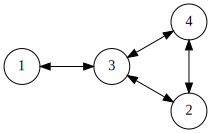

In [15]:
n = 4 # number of rooms
S = range(1,n+1)
P = dtmc.rand_maze(n, p = [0,0.2,0.4,0.4])

dtmc.disp_dtmc(P, S, frac=True)
display(mcviz.dot_mc(P, S, engine='circo', bidir=True))

### Exercise 6.3 (Optional)

Find the distribution $\pi$ that satisfies $\pi = \pi \mathbf{P}$, $\pi \geq 0$, $\sum_j \pi_j = 1$ where $\mathcal{S} = \{1, 2, 3\}$ and
$$\mathbf{P} =
  \begin{pmatrix}
    0.5 & 0.25 & 0.25 \\
    0 & 0.2 & 0.8 \\
    0 & 0.8 & 0.2
  \end{pmatrix}$$